In [1]:

%load_ext autoreload

%autoreload 2

from RNN2DFA.LSTM import LSTMNetwork
# from GRU import GRUNetwork
from RNN2DFA.RNNClassifier import RNNClassifier
from RNN2DFA.Training_Functions import mixed_curriculum_train,make_train_set_for_target
import Tomita_Grammars 
from lstar_extraction.Training_Functions import make_test_set
from RNNexplainer import Explainer







In [2]:
# make training set
target = Tomita_Grammars.tomita_11
alphabet = "abc"


# use a dfa to generate training set
target_formula="F(aUb)"
fout=open("log.txt", "a")
fout.write(".........................................................................\n")
fout.write("Target: "+ target_formula)
fout.write("\n")
fout.close()
import LTL2DFA as ltlf2dfa
generator_dfa=ltlf2dfa.translate_ltl2dfa(alphabet=[character for character in alphabet],formula=target_formula)
print(generator_dfa)


# alphabet = "abcd"
train_set = make_train_set_for_target(generator_dfa.classify_word,alphabet)

# define rnn
rnn = RNNClassifier(alphabet,num_layers=1,hidden_dim=10,RNNClass = LSTMNetwork)


print(train_set)


DFA:->
 - alphabet: ['a', 'b', 'c']
 - Q: [1, 2, 3]
 - q0: 1
 - F: [3]
 - delta: {1: {'000': 2, '001': 2, '100': 2, '101': 2, '010': 3, '011': 3, '110': 3, '111': 3}, 2: {'000': 2, '001': 2, '100': 2, '101': 2, '010': 3, '011': 3, '110': 3, '111': 3}, 3: {'000': 3, '001': 3, '010': 3, '011': 3, '100': 3, '101': 3, '110': 3, '111': 3}}
 - is_singleton_graph: False
made train set of size: 934 , of which positive examples: 622
The dy.parameter(...) call is now DEPRECATED.
        There is no longer need to explicitly add parameters to the computation graph.
        Any used parameter will be added automatically.
{'': False, 'b': True, 'c': False, 'a': False, 'bb': True, 'ba': True, 'bc': True, 'ab': True, 'cb': True, 'aa': False, 'ca': False, 'ac': False, 'cc': False, 'cab': True, 'bcb': True, 'cbb': True, 'baa': True, 'abb': True, 'cbc': True, 'bca': True, 'cba': True, 'ccb': True, 'abc': True, 'bba': True, 'aba': True, 'bbc': True, 'acb': True, 'bac': True, 'bcc': True, 'bab': True, 'aa

current average loss is:  0.013116273873041194
current average loss is:  0.002661438138963015
current average loss is:  0.0015585477220101168
current average loss is:  0.0009837512131766236
current average loss is:  0.0006020782568483502


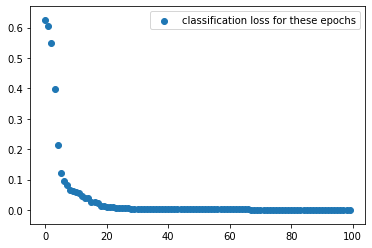

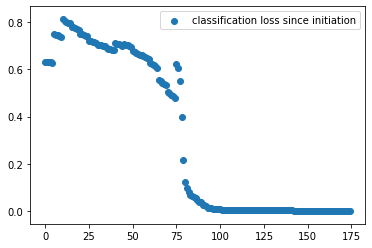

current average loss is:  0.0005104082618586767


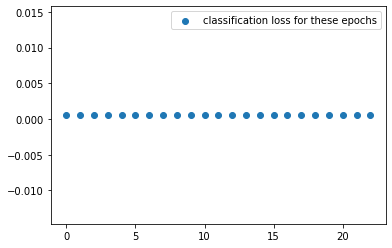

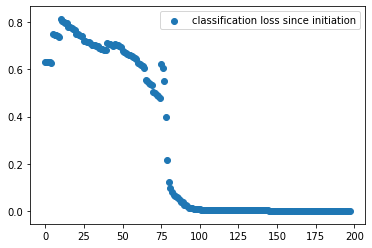

classification loss on last batch was: 0.000499185964433233


In [3]:
# train the model
mixed_curriculum_train(rnn,train_set,stop_threshold = 0.0005)
rnn.renew()  


In [4]:
"""  
from lstar implementation
"""

if(False):

    # starting examples
    # all_words = sorted(list(train_set.keys()),key=lambda x:len(x))
    # pos = next((w for w in all_words if rnn.classify_word(w)==True),None)
    # neg = next((w for w in all_words if rnn.classify_word(w)==False),None)
    # starting_examples = [w for w in [pos,neg] if not None == w]



    # extract DFA from RNN
    from RNN2DFA.Extraction import extract


    dfa_from_rnn = extract(rnn,time_limit = 50,initial_split_depth = 10,starting_examples=None)


    # some statistics
    from math import pow
    def percent(num,digits=2):
        tens = pow(10,digits)
        return str(int(100*num*tens)/tens)+"%"

    dfa_from_rnn.draw_nicely(maximum=30) #max size willing to draw

    test_set = train_set 
    print("testing on train set, i.e. test set is train set")
    # we're printing stats on the train set for now, but you can define other test sets by using
    # make_train_set_for_target again

    n = len(test_set)
    print("test set size:", n)
    pos = len([w for w in test_set if target(w)])
    print("of which positive:",pos,"("+percent(pos/n)+")")
    rnn_target = len([w for w in test_set if rnn.classify_word(w)==target(w)])
    print("rnn score against target on test set:",rnn_target,"("+percent(rnn_target/n)+")")
    dfa_rnn = len([w for w in test_set if rnn.classify_word(w)==dfa_from_rnn.classify_word(w)])
    print("extracted dfa score against rnn on test set:",dfa_rnn,"("+percent(dfa_rnn/n)+")")
    dfa_target = len([w for w in test_set if dfa_from_rnn.classify_word(w)==target(w)])
    print("extracted dfa score against target on rnn's test set:",dfa_target,"("+percent(dfa_target/n)+")")

else:
    """  
    Igor's code:
    The model itself is implemented as a DFA. 
    """


    dfa_from_rnn=rnn 

In [27]:
# use a query LTL formula
import LTL2DFA as ltlf2dfa
query_formula="false"
query_dfa=ltlf2dfa.translate_ltl2dfa(alphabet=[character for character in alphabet],formula=query_formula)
print(query_dfa)
# query_dfa=No


# make test_set supported by query dfa
sample_test_set=make_train_set_for_target(query_dfa.classify_word, alphabet)

# only consider sample that are true
test_set=[]
for key in sample_test_set:
    if(sample_test_set[key]):
        test_set.append(key)
print(test_set[:30])

DFA:->
 - alphabet: ['a', 'b', 'c']
 - Q: [0, 1]
 - q0: 0
 - F: []
 - delta: {0: {'000': 1, '001': 1, '010': 1, '011': 1, '100': 1, '101': 1, '110': 1, '111': 1}, 1: {'000': 1, '001': 1, '010': 1, '011': 1, '100': 1, '101': 1, '110': 1, '111': 1}}
 - is_singleton_graph: True
made train set of size: 333 , of which positive examples: 0
[]


In [28]:
from PACTeacher.pac_teacher import PACTeacher as Teacher 

# query_dfa=None

if(query_dfa is None):
    query_formula=None
    test_set=make_test_set(alphabet)


from RNNexplainer import Traces
traces=Traces(rnn, alphabet)
traces.label_from_network(test_set)
traces.write_in_file()


explainer=Explainer(alphabet=[character for character in alphabet])
teacher = Teacher(dfa_from_rnn,epsilon=.001, delta=.001, max_trace_length=10, max_formula_depth=10, query_dfa=query_dfa)
from time import clock
start_time=clock()
flag=teacher.teach(explainer,traces)
end_time=clock()


print("\n\nepsilon=", teacher.epsilon, "delta=", teacher.delta, "max_trace_length=", teacher.max_trace_length)
print("query:", query_formula)
print("final ltl: ", explainer.ltl)

fout=open("log.txt", "a")
fout.write("\n\nquery: "+query_formula)
fout.write("\nfinal LTL: "+ explainer.ltl)
if(not flag):
    fout.write(" [incomplete]")
    print("incomplete formula")
fout.write("\n\n")

print("\nTime taken:", end_time-start_time)

fout.close()



positive traces---> 
[]


negative traces---> 
[]



0
learned LTL formula: false


epsilon= 0.001 delta= 0.001 max_trace_length= 10
query: false
final ltl:  false

Time taken: 2.396384999999995
